# Исследование оттока клиентов в фитнес-клубе


**Цель** - На основе данных о посетителях сети фитнес-центров спрогнозировать вероятность оттока для каждого клиента в следующем месяце, сформировать с помощью кластеризации портреты пользователей


В работе планируется сделать следующие шаги:

- [1. Провести исследовательский анализ данных (EDA)](#step1)
    - [1.1. Предварительный анализ ](#step2)
    - [1.2.Анализ средних значений признаков](#step3)
    - [1.3.Анализ столбчатых гистограмм и матрицы корреляций](#step4)

- [2. Выбор модели прогнозирования оттока пользователей](#step5):

- [3. Сделать кластеризацию пользователей](#step6) 
    - [3.1.Выбрать количество кластеров, используя матрицу расстояний и дендрограмму](#step7) 
    - [3.2. Обучить модель кластеризации на основании алгоритма K-Means и спрогнозировать кластеры клиентов. ](#step8)
    - [3.3.Охарактеризовать кластеры.](#step9) 

- [4.Выводы и рекомендации по работе с клиентами.](#step14)

In [1]:
#импортирование библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

#pd опции 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

sns.set()

In [2]:
# используемые функции

def firstlook_df(df):
    '''
    Функция для датафрейма df выводит:
    - первые и последние 5 строчек таблицы, 
    -общую информацию о таблице,
    -количество дубликатов и пропусков   
    '''
    separator_line =25*('--')
    print(separator_line)
    print('Первые 5 строк таблицы:')
    print(separator_line)
    display(df.head())
    print(separator_line)
    print('Последние 5 строк таблицы:')
    print(separator_line)
    display(df.tail())
    
    print(separator_line)
    print('Общая информация о данных:')
    print(separator_line)
    display(df.info()) 
    
    print(separator_line)
    print('Проверка на наличие дубликатов и пропусков:')
    print(separator_line) 
    print('Количество строк-дубликатов = ', df.duplicated().sum())
    for column in df.columns:
        n_nulls = df[column].isnull().sum()
        print(f'Количество пропусков в столбце {column} = {n_nulls}')
    print(separator_line)    
    
# названия для графиков
hist_label = {1:'Ушли',0:'Остались'}  

columns_rus = {'contract_period':'Длительность контракта, мес.', 
              'age':'Возраст клиента, лет', 
              'avg_additional_charges_total':'Суммарная выручка с клиента, руб.', 
              'month_to_end_contract':"Осталось до конца контракта, мес.", 
              'lifetime':"Время с первого обращения, мес.", 
              'avg_class_frequency_total':"Частота занятий в неделю за все время", 
              'avg_class_frequency_current_month':"Частота занятий в неделю в текущем месяце",
              'gender':'Пол', 
               'near_location':'Удобный район',
               'partner':"Участник партнерской программы",
               'promo_friends':"Участник акции для друзей",
               'phone':"Телефон", 
               'group_visits':"Посещение групповых занятий",
              'churn':'Отток'}

# 
def plot_feature_hist(features, data,  x_label, hist_label, monthly_columns = False):
    '''функция строит гистограмму и распределение признаков из столбцов features по данным data
        x_label и hist_label задают имена признаков и факта оттока на графике
    '''
    for column in features:
        #print(column)
        plt.figure(figsize = (10,6))

        for churn, data_grouped in data.groupby('churn')[column]:
            #print (churn)
            if monthly_columns:
                ax = sns.distplot(data_grouped, kde = False, label = hist_label[churn], bins=range(0, 13, 1))
            else:
                ax = sns.distplot(data_grouped, label = hist_label[churn])
            ax.legend()
            ax.grid(True)
            ax.set(title = "Гистограмма признака = " + column,
                    xlabel = x_label[column],
                    ylabel = "Частота")
        plt.show() 
        
def plot_means_by_cat(data, features, category, columns_rus, xlabel = " "):
    #  средние значения небинарных признаков
    nrows = math.floor((len(features)+1)/2)
    fig, axes = plt.subplots(nrows, 2, figsize = (nrows*4,14) )
    axes = axes.flatten()
    for column, ax_ in zip(features, axes):
        sns.barplot(x = category, y = column,  data=data, ax = ax_)
        ax_.grid(True)
        ax_.set(title = "Признак = " + columns_rus[column] ,
                xlabel = xlabel, 
                ylabel = ' ')
        ax_.set_xticklabels(['Остались','Ушли']) #, rotation='vertical', fontsize=10)
    fig.suptitle('Средние значения для различных признаков')
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    

def plot_feature_dist_by_claster(data, features, columns_rus, x_lim = None):
    '''
    функция строит графики распределения для признаков feature по данным data
    для разных кластеров
    '''
    for column in features:

        plt.figure(figsize = (12,7))

        for label, grouped_data in data.groupby('label')[column]:

            ax_= sns.distplot(grouped_data, color = 'C'+str(label),kde_kws=dict(linewidth=3),
                              label = " Кластер = "+ str(label),
                              hist=False)

            ax_.axvline(x = grouped_data.mean() ,linewidth=2, linestyle = '--',  
                        color = 'C'+str(label), 
                        label = "среднее = "+ str(round(grouped_data.mean(),2)) ) 

            ax_.legend()
            ax_.grid(True)
            ax_.set(title = "Функция распределения признака = " + column,
                    xlabel = columns_rus[column],
                    ylabel = "Вероятность")
            
            if x_lim:
                ax_.set_xlim(right =  x_lim)


In [3]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    #print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    #print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

#  1. Исследовательский анализ данных (EDA)  <a id="step1">


    
## 1.1.  Предварительный анализ  <a id="step2">

In [4]:
#  чтение данных 
fitness_users = pd.read_csv('gym_churn.csv')
firstlook_df(fitness_users)

# перевод названий столбцов в нижний регистр
fitness_users.columns = map(str.lower,fitness_users.columns )

#fitness_users['churn_label'] = fitness_users['churn'].apply(lambda x: 'Ушел' if x == 1 else 'Остался')
#display(fitness_users.head())
# статистика по столбцам данных
fitness_users.describe()

--------------------------------------------------
Первые 5 строк таблицы:
--------------------------------------------------


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


--------------------------------------------------
Последние 5 строк таблицы:
--------------------------------------------------


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3995,1,1,1,0,1,12,0,33,2.41,12.00,8,2.28,2.35,0
3996,0,1,0,0,1,1,1,29,68.88,1.00,1,1.28,0.29,1
3997,1,1,1,1,1,12,0,28,78.25,11.00,2,2.79,2.83,0
3998,0,1,1,1,1,6,0,32,61.91,5.00,3,1.63,1.60,0
3999,1,0,1,0,0,12,1,30,178.86,12.00,1,1.10,1.04,0


--------------------------------------------------
Общая информация о данных:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn          

None

--------------------------------------------------
Проверка на наличие дубликатов и пропусков:
--------------------------------------------------
Количество строк-дубликатов =  0
Количество пропусков в столбце gender = 0
Количество пропусков в столбце Near_Location = 0
Количество пропусков в столбце Partner = 0
Количество пропусков в столбце Promo_friends = 0
Количество пропусков в столбце Phone = 0
Количество пропусков в столбце Contract_period = 0
Количество пропусков в столбце Group_visits = 0
Количество пропусков в столбце Age = 0
Количество пропусков в столбце Avg_additional_charges_total = 0
Количество пропусков в столбце Month_to_end_contract = 0
Количество пропусков в столбце Lifetime = 0
Количество пропусков в столбце Avg_class_frequency_total = 0
Количество пропусков в столбце Avg_class_frequency_current_month = 0
Количество пропусков в столбце Churn = 0
--------------------------------------------------


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00



- В таблице 4000 строк-пользователей и 14 колонок (13 признаков и 1 целевая переменная - Churn), нет пропусков и типы данных соответстуют значениям
- 6 переменных - бинарные (принимают значение 0 или 1): 'gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits'
- 7 небинарных переменных: 'Contract_period', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month'
- Для дальнейшего удобства названия столбцов переведены в нижний регистр

- Анализируя средние значения и стандартные отклонения, можно сделать следующие выводы:

    - за месяц ушло 27% посетителей (среднее значение Churn = 0.27); 
    - половой состав посетителей - примерно 50/50 мужчины и женщины; 
    - 85% клиентов живет или работает в районе, где находится фитнес-клуб; 
    - 90% посетителей оставляет свой телефон; 
    - 49% пользуются фитнес-клубом в рамках партнерской программы от работодателя; 
    - примерно 30% воспользовались промокодом от друзей;
    - 41% клиентов посещали групповые занятия;
    - средний возраст посетителей - 29 лет;
    - среднее количество месяцев до конца контракта и средняя длина контакта - примерно 4 месяца, 50% клиентов с контрактом от 1 до 6 месяцев;
    - в среднем клиенты посещают фитнес-клуб в течение 3 месяцев и 20 дней, 50% клиентов - от 1 до 5 месяцев, максимум - 31 месяц;
    - средняя выручка от других услуг фитнес-клуба с 1 клиента = 136 руб; 
    - в среднем клиент  посещает 1.88 класса в неделю, а в текущем месяце - 1.77, но есть максимум в 6,15 классов

## 1.2. Анализ средних значений признаков  <a id="step3">

Рассмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [5]:
# разделим  бинарные и небинарные признаки

nonbinary_features = []
binary_features = []
for column in fitness_users.drop(['churn'], axis = 1).columns:
    if fitness_users[column].value_counts().index.isin([0,1]).all():
        binary_features.append(column )
    else:
        nonbinary_features.append(column)
print('Числовые признаки:')
print(nonbinary_features)
print('Бинарные признаки:')
print(binary_features)

Числовые признаки:
['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
Бинарные признаки:
['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']


,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,
0,5.75,29.98,158.45,5.28,4.71,2.02,2.03
1,1.73,26.99,115.08,1.66,0.99,1.47,1.04


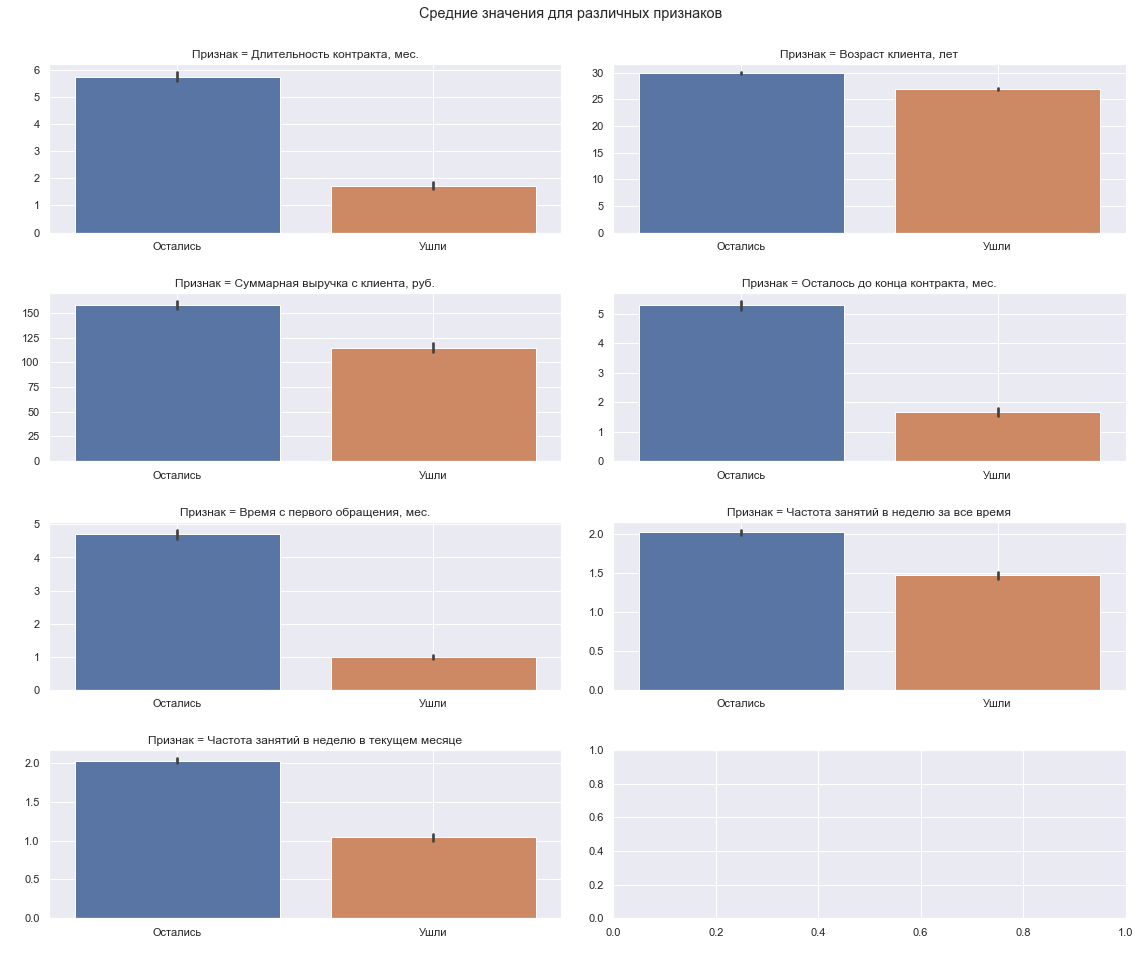

In [6]:
# средние значения числовые признаки
display(fitness_users.groupby('churn')[nonbinary_features].mean())
#построим средние значения
plot_means_by_cat(fitness_users, nonbinary_features, 'churn', columns_rus)    


,gender,near_location,partner,promo_friends,phone,group_visits
churn,,,,,,
0,0.51,0.87,0.53,0.35,0.90,0.46
1,0.51,0.77,0.36,0.18,0.90,0.27


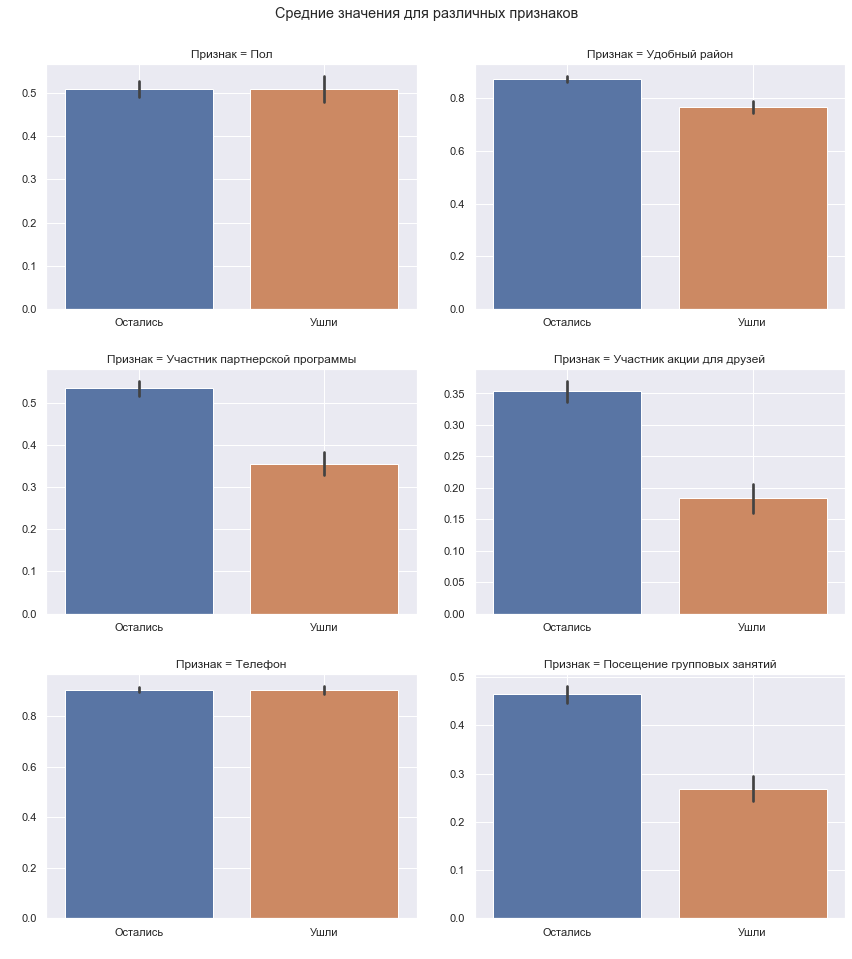

In [7]:
#  средние значения бинарных признаков
display(fitness_users.groupby('churn')[binary_features].mean())
plot_means_by_cat(fitness_users, binary_features, 'churn', columns_rus) 

-  **Средние значения** отличаются в двух группах (те, кто ушел и те, кто остался), особенно:

    - в возрасте (29.9 лет у тех, кто остался vs 26.9 лет среди тех, кто ушел), 
    - в общем периоде контакта (5.75 месяцев у тех, кто остался, vs 1.73 месяцев) и количестве месяцев до конца контакта(5.28  vs 1.66), эти два признака сильно взаимосвязаны
    - среднее количество занятий в неделю (в текущем месяце и за все время ), отличаются в 2 или 1,5 раза (2 vs 1.04 или 1.47)
    - те, кто остался, в среднем были в клубе уже 4 месяц 20 дней, а те, кто ушел, около месяца
    - также среди тех, кто ушел, в 2 раза меньше посещавших групповые занятия (27% vs 46%), они реже приходят по приглашению друзей (18% vs 35%) или являются сотрудниками компаний партнеров (36% vs 53%), среди них меньше тех, кто живет или работает в одном районе с фитнес-клубом
    - суммарная выручка с тех клиентов, что ушли, ниже, что логично - люди перестают ходить в клуб и, соответсвенно, не тратят там деньги
    

## 1.3. Анализ столбчатых гистограмм и матрицы корреляций <a id="step4">

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

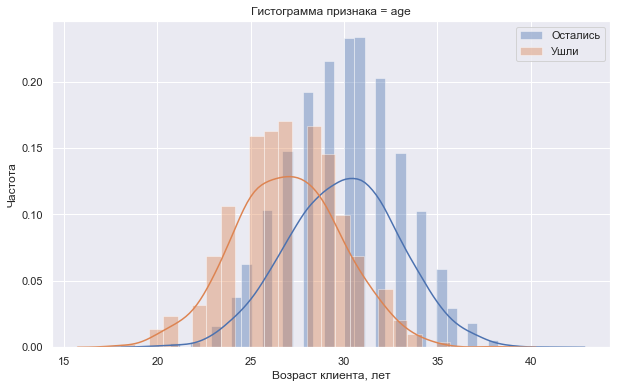

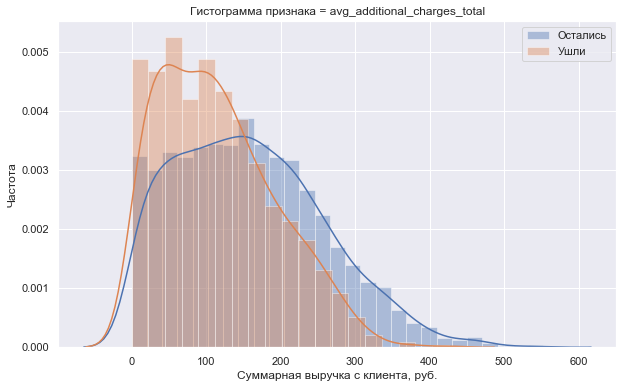

In [8]:
#  первые 4 признака
plot_feature_hist(nonbinary_features[1:3], fitness_users, columns_rus, hist_label)


- **Возраст** - те, кто остаются,  старше (средний возраст около 30 лет,  а уходит молодежь - 26). После 35 вообще практически никто не уходит, видимо, с возрастом люди осознаннее подходят к покупке абонемента в фитнес-клуб.
- **Средняя выручка с допуслуг** - у тех, кто остался, она выше - те, кто активно посещает фитнес  либо дольше ходят в клуб, тратят больше денег на допуслуги

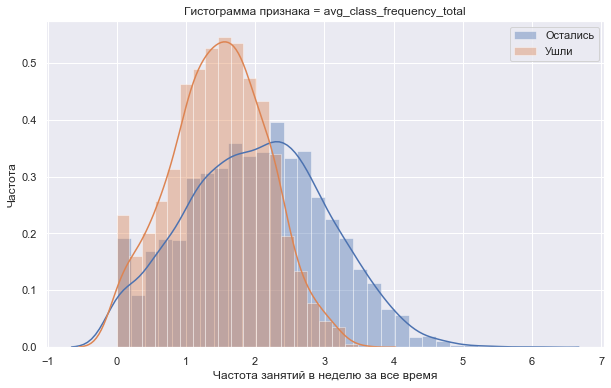

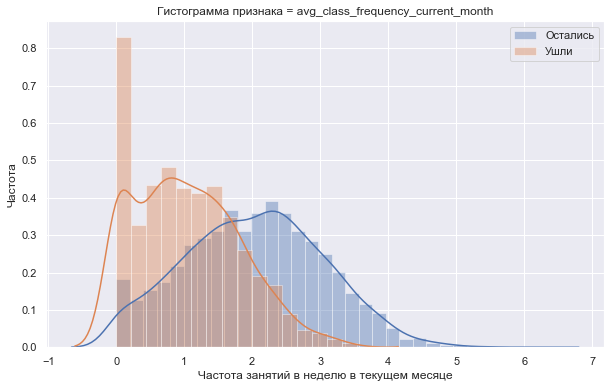

In [9]:
plot_feature_hist(nonbinary_features[5:], fitness_users, columns_rus, hist_label)

 **Средняя частота посещений в неделю за все время и в текушем месяце** 
- у тех, кто остался сушественно выше частота посещений в текущем месяце, чуть менее заметна разница в частоте посещений за все время. В гистограмме для тех, кто ушел, заметен большой пик около 0 - наверно, люди покупают абонемент в качестве мотивации, но не очень помогает) Те клиенты, которые посещают занятия, с большей вероятностью будут продолжать ходишь на занятия.

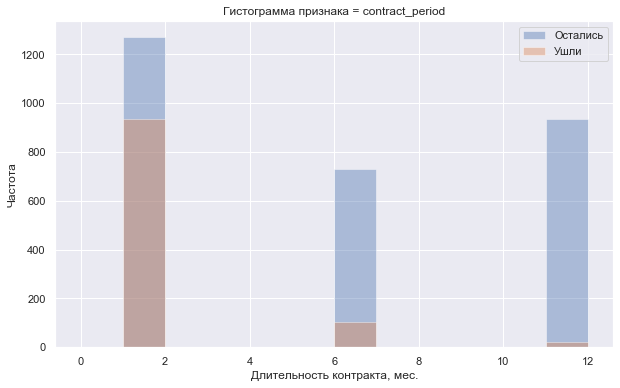

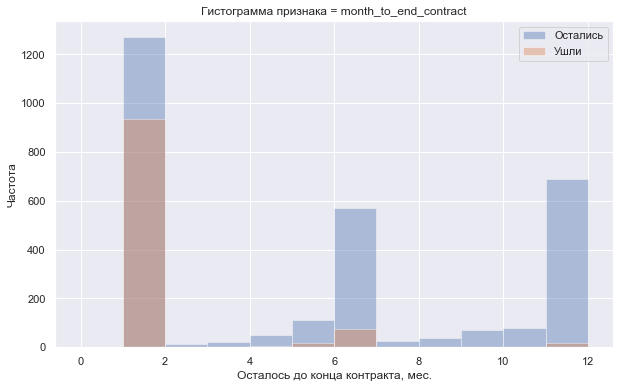

In [10]:
# 
plot_feature_hist(['contract_period', 'month_to_end_contract'], fitness_users, columns_rus, hist_label, True)

**Длительность контракта и количество месяцев до конца контракта** 

- cреди тех, кто ушел, подавляющее большинство -  это люди с контактом на один месяц (пробуют и не остаются). Скорее всего, такое поведение характерно для новых клиентов любого фитнес-клуба в принципе, но возможно клиентов что-то не устраивает именно в этом клубе - не подходит расписание, цена, не нравится персонал и т.п. Среди тех, кто остался, распределение по периодам контракта более равномерное - клиентов с контактом в 1 месяц много, но соизмеримо с другими категориями, не больше 50%. 
- Среди тех, кто ушел, практически нет людей с конрактом в 12 месяцев

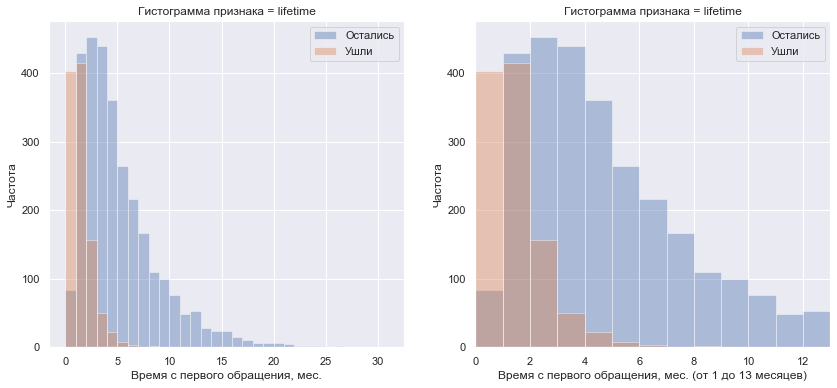

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,2939.00,4.71,3.87,0.00,2.00,4.00,6.00,31.00
1,1061.00,0.99,1.11,0.00,0.00,1.00,1.00,9.00


Границы 95 97 и 99 персентиля, все данные
[11. 13. 17.]
Границы 95 97 и 99 персентиля, только оставшиеся
[12.   14.   18.62]


In [11]:
#  время с первого посещения

column = 'lifetime'
fig, axes = plt.subplots(1, 2, figsize = (14,6))
for i in range(0,2):
    ax = axes[i]
    #print(axes)
    for churn, data in fitness_users.groupby('churn')[column]:
            #print (churn)

            sns.distplot(data, kde = False, 
                         label = hist_label[churn], 
                         bins=range(0, data.max()+1, 1), 
                         ax = ax )
            ax.legend()
            ax.grid(True)
            ax.set(title = "Гистограмма признака = " + column,
                    xlabel = columns_rus[column],
                    ylabel = "Частота")
            
    if i == 1:
        ax.set_xlim([0,13])
        ax.set_xlabel(columns_rus[column]+' (от 1 до 13 месяцев)')
plt.show() 


display(fitness_users.groupby('churn')['lifetime'].describe())
print('Границы 95 97 и 99 персентиля, все данные')
print(np.percentile(fitness_users['lifetime'], [95, 97, 99]))

print('Границы 95 97 и 99 персентиля, только оставшиеся')
print(np.percentile(fitness_users.query('churn == 0')['lifetime'], [95, 97, 99]))


**время с первого посещения фитнес-клуба** 

- Те, кто ушел,впервые пришли в клуб не больше чем 9 месяцев назад, а чаще всего 0 или 1 месяца назад. Среди тех,  кто остался, примерно поровну людей пришедших от 1 до 6 месяцев назад, хотя есть и выделяющиеся значения (31 месяц).
Чтобы большие выбросы не влияли на результаты исследования, отфильтруем данные по lifetime, за границу мы возьмем 13 месяцев - это 97% всех клиентов и между 95 и 97% тех клиентов, которые не ушли.

Отфильтруем данные и построем матрицу корреляций.

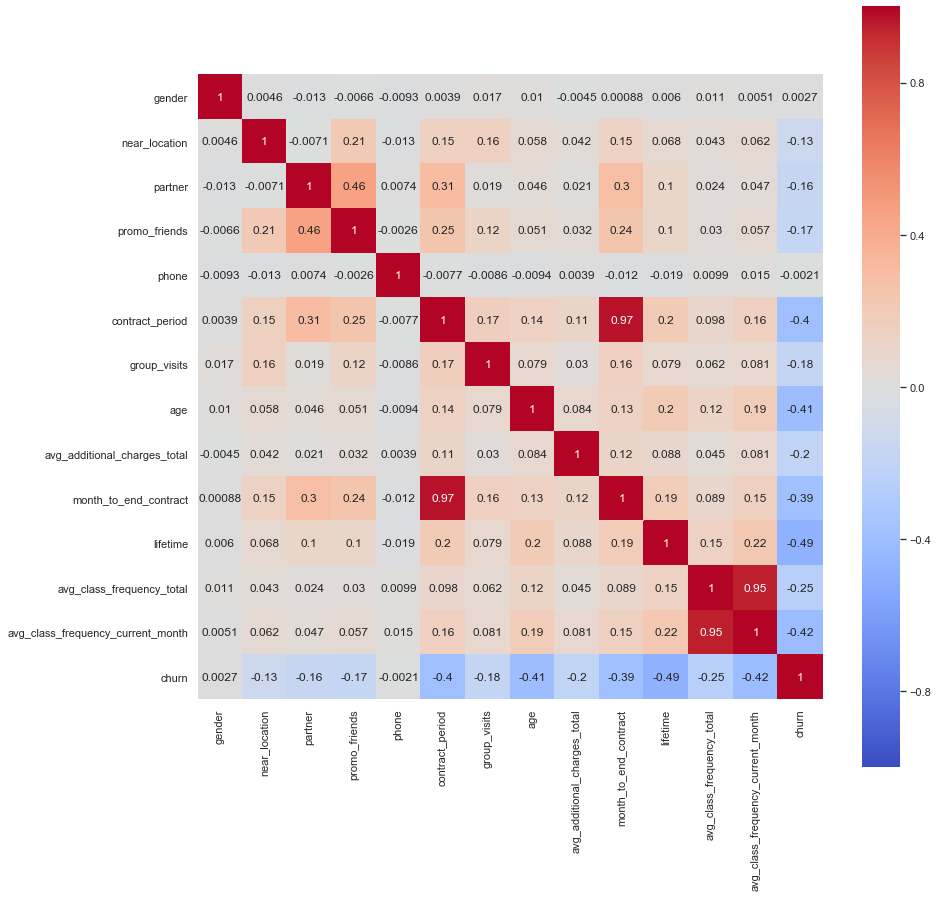

In [12]:
lifetime_cut =  13 # убираем выбросы
fitness_users_ftr = fitness_users.query('lifetime < @lifetime_cut ')

# корреляционная матрица
corr_matrix = fitness_users_ftr.corr()
plt.figure(figsize = (14,14))

# тепловая карта корреляций
sns.heatmap(corr_matrix, annot=True,  square=True,vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

Анализ   **матрицы корреляций**:
- самые сильная корреляция между фактом оттока и:

    - временем с момента первого обращения в клуб (-0.48)
    - средним количеством классов (-0.42) в текущем месяце 
    - возрастом (-0.41)
    - периодом контракта (-0.39)
    - кол-вом месяцев до конца контракта (-0.39) 
    
    Все коэффициенты корреляции отрицательные - чем больше значение принимают эти признаки, тем выше вероятность, что клиент останется (churn = 0). Чем дольше человек ходит в этот клуб, чем большее количество занятий посещает, чем он старше, тем вероятнее, что он не уйдет.
    
- сильнее всего друг c другом коррелируют:

    - среднее количество занятий в текущем месяце и всего за весь период(0.95)
    - общее время контракта и количество месяцев до конца контракта(0.97)

# 2. Выбор модели прогнозирования оттока пользователей  <a id="step5">

Постройте модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце. Разобьем данные на обучающую и валидационную выборк и стандартизируем их.

In [13]:
#print(fitness_users_ftr.columns)['churn', 'month_to_end_contract', 'avg_class_frequency_total']
X = fitness_users_ftr.drop(['churn'], axis = 1)  # признаки
y = fitness_users_ftr['churn']     # целевая функция

# разделяем на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)
print('Размер обучающей выборки =',X_train.shape)
print('Размер валидационной выборки =', X_test.shape)

# стандартизуем данные
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Размер обучающей выборки = (3088, 13)
Размер валидационной выборки = (773, 13)


Обучим модель на train-выборке двумя способами:  логистической регрессией и случайным лесом и сравним их результаты прогноза. 

In [14]:
print('---'*20)
print('Логистическая регрессия')
model = LogisticRegression(random_state=0)
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]
print_all_metrics(y_test, predictions, probabilities, title = 'Метрики классификации')
features = pd.DataFrame(data = {'features':X.columns, 'importance': model.coef_[0,:]})
features['abs_importance'] = [abs(x) for x in features['importance']]
print('Самые важные признаки:')
print(features.sort_values(by = 'abs_importance', ascending = False).head(5))


print('---'*20)
print('Случайный лес')
model = RandomForestClassifier(n_estimators = 100, random_state=0)
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]
print_all_metrics(y_test, predictions, probabilities, title = 'Метрики классификации')
features = pd.DataFrame(data = {'features':X.columns, 'importance':model.feature_importances_})
print('Самые важные признаки:')
print(features.sort_values(by = 'importance', ascending = False).head(5))
print('\n')

------------------------------------------------------------
Логистическая регрессия
Метрики классификации
	Accuracy: 0.93
	Precision: 0.88
	Recall: 0.83
Самые важные признаки:
                             features  importance  abs_importance
12  avg_class_frequency_current_month       -4.18            4.18
11          avg_class_frequency_total        3.11            3.11
10                           lifetime       -2.91            2.91
7                                 age       -1.15            1.15
9               month_to_end_contract       -0.74            0.74
------------------------------------------------------------
Случайный лес
Метрики классификации
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.76
Самые важные признаки:
                             features  importance
10                           lifetime        0.27
12  avg_class_frequency_current_month        0.17
7                                 age        0.13
11          avg_class_frequency_total        0.13
8        a

**Результаты:**
- Логистическая регрессия:
   - Accuracy: 0.93
   - Precision: 0.88
   - Recall: 0.83

- Случайный лес:
    - Accuracy: 0.91
    - Precision: 0.85
    - Recall: 0.76
        
- У логистической регрессии выше метрики: доля правильных ответов(accuracy) = 0.93 против 0.91 у случайного леса. Точность(precision) = 0.88 также выше (против 0.85) - это означает, что предположение, что клиент уйдет, будет правильным в 88% случаев. У метода логистическая регрессия намного выше полнота(recall) = 83% против 76%  у случайного леса. Так как для нас важнее не пропустить клиента, который собирается уйти, чтобы заинтересовать его, то полнота является самым важным параметром - важно уменьшить количество false negative и увеличить true positive, по этому параметру сильно выигрывает логистическая регрессия.

- так же если рассмотреть коэффициенты регрессии или параметр важность признаков в случайном лесе, можно заметить, что сильнее всего на целевую переменную влияют  как раз сильно коррелирующие с ней признаки -  время с первого посещения клуба, возраст, длительность контракта, среднее количество классов в неделю всего и за текущий месяц

# 3. Кластеризация пользователей

## 3.1. Агломеративная иерархическая кластеризация
    
    Построим матрицу расстояний функцией linkage() и нарисуем дендрограмму.

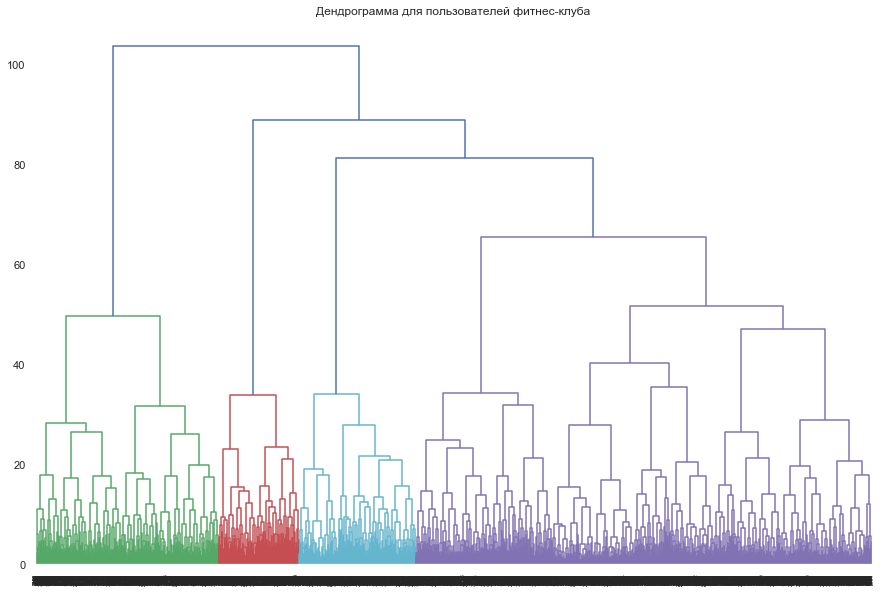

In [15]:
# стандартизируем все данные 
X_st = scaler.fit_transform(X) 

linked = linkage(X_st, method = 'ward')  #  матрица расстояний

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top') # дендрограмма
plt.title('Дендрограмма для пользователей фитнес-клуба')
plt.show()

- Предположительно, можно выделить 4 кластера  пользователей (4 цвета на дендрограмме).

 ## 3.2  Кластеризация методом K-Means
    - Посмотрите на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
     - Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?
    - Для каждого полученного кластера посчитайте долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [16]:
# стандартизируем все данные для разбивки по кластерам
X_st = scaler.fit_transform(fitness_users.drop('churn', axis = 1))  
km = KMeans(n_clusters = 5, random_state = 0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_st)  # применяем алгоритм к данным и формируем вектор кластеров

fitness_users['label'] = labels

# средние значения признаков по кластерам
fitness_users.groupby(['label']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
label,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.00,10.88,0.54,29.98,160.71,9.95,4.74,1.98,1.98,0.03
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.72,2.46,4.90,2.85,2.85,0.07


Посмотрим на средние значения признаков для кластеров:

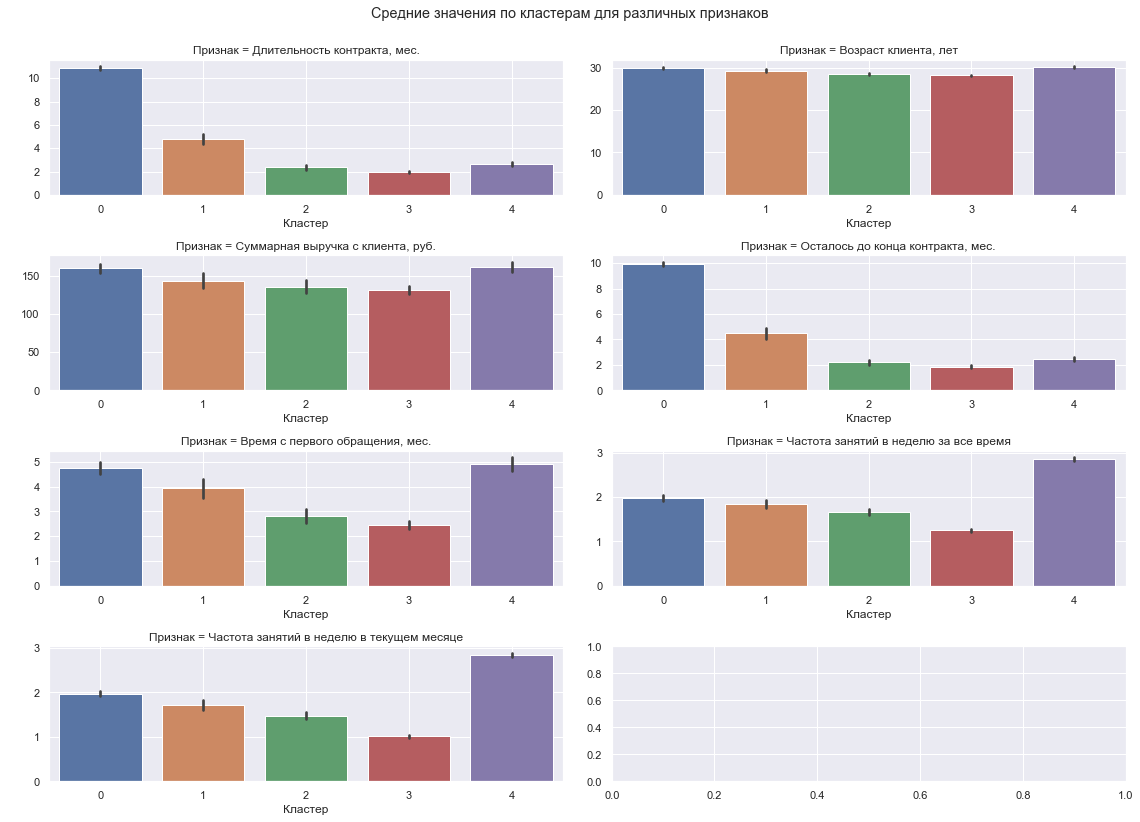

In [17]:
#  средние значения небинарных признаков
fig, axes = plt.subplots(4, 2, figsize = (16,12) )
axes = axes.flatten()
for column, ax_ in zip(nonbinary_features, axes):
    sns.barplot(x = "label", y = column,  data=fitness_users, ax = ax_)
    ax_.grid(True)
    ax_.set(title = "Признак = " + columns_rus[column],
            xlabel = 'Кластер', 
           ylabel = ' ')
    
fig.suptitle('Средние значения по кластерам для различных признаков')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

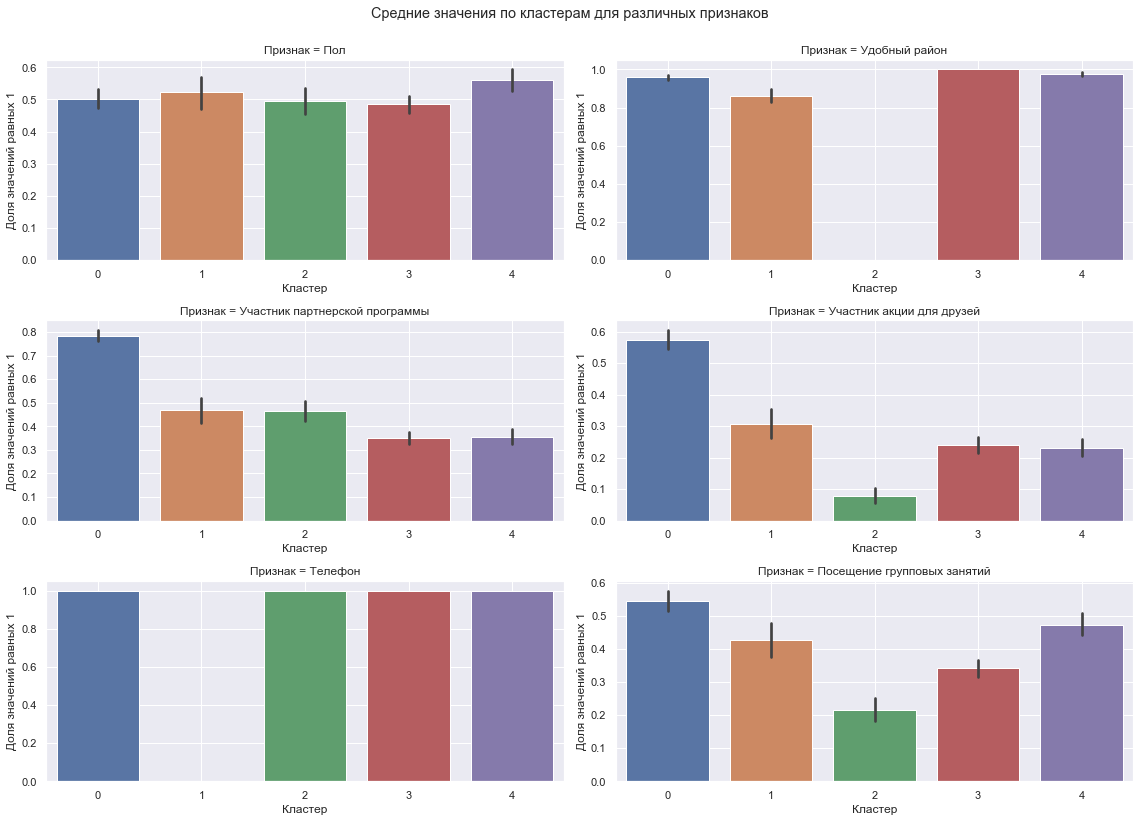

In [18]:
# средние значения бинарных признаков

fig, axes = plt.subplots(3, 2, figsize = (16,12) )
axes = axes.flatten()
for column, ax_ in zip(binary_features, axes):
    sns.barplot(x = "label", y = column,  data=fitness_users, ax = ax_)
    ax_.grid(True)
    ax_.set(title = "Признак = " + columns_rus[column],
            xlabel = 'Кластер', 
           ylabel = 'Доля значений равных 1')
    
fig.suptitle('Средние значения по кластерам для различных признаков')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

**Средние значения признаков для кластеров** 

- **Кластер  №0**:
    - Средняя продолжительность контакта и сколько осталось до окончания контакта здесь намного выше, чем у остальных - примерно 10 месяцев, 
    -  время с первого посещения примерно 4.5 месяца
    -  частота занятий чуть выше среднего, но не максимальная
    -  с вероятностью 90% клиент живет илим работает в этом районе
    -  в этом кластере наибольший процент людей пришедших по партнерской программе или про приглашению друзей(примерно 70% и 60% соотвественно) 
    - вероятнее других кластеров посетил хотя бы одно групповое занятие, что логично с такой длительностью абонемента, намного больше было возможностей пойти на занятие за это время
   Мне кажется, это такой кластер людей, купивших длительный абонемент(около года) по партнерской программе или по скидке от друзей, и среди них микс тех, кто часто ходит в спортзал, и кто не очень, но верят, что вот-вот начнут)
   
- **Кластер  №1**:

    - Средняя продолжительность контакта и сколько осталось до окончания контакта здесь вторая среди кластеров и равна примерно 5 месяцев, 
    -  время с первого посещения чуть меньше 4 месяцев
    -  частота занятий средняя
    -  с вероятностью 80% клиент живет илим работает в этом районё
    - никто не оставил свой телефон (наверное, им не приходят новости об акциях проходяших или трудно оповестить о изменениях в расписании и тп)
    -  в этом кластере намного меньше участников партнерской программы или пришедших по приглашению друзей(около 40%) 
    
- **Кластер  №2**:

    - Средняя продолжительность контакта и сколько осталось до окончания контакта  равна примерно 2 месяцам, 
    -  время с первого посещения примерно 2 месяца
    -  очень выделяется, что здесь все клиенты, которые не живут и не работают в этом районе - для них район не удобный
    -  лишь около 10% пришло по приглашению от друзей
    
     последние два пункта делают клуб не очень привлекательным логистически - неудобно расположен и меньше вероятность, что у клиента есть друзья в клубе, с которыми он может вместе ходить на занятия.
     
- **Кластер  №3**:
    - Это самые свежие клиенты - средняя продолжительность контакта и сколько осталось до окончания контакта меньше 2 месяцев 
    -  время с первого посещения меньше 2 месяцев
    -  частота посещения занятий самая низкая 
    Похоже на новичков, которые купили абонемент в фитнес, но быстро потеряли мотивацию и перестали посещать клуб
    
 - **Кластер  №4**:
 
    - Средняя продолжительность контакта короткая и сколько осталось до окончания контракта здесь примерно равно 2 месяцам 
    -  время с первого посещения чуть меньше 4 месяцев
    -  частота занятий всего и в текущем месяце самая высокая (3), 
    похоже на очень мотивированных клиентов, которые недавно посещают клуб

Построим распределения признаков для кластеров для числовых признаков:

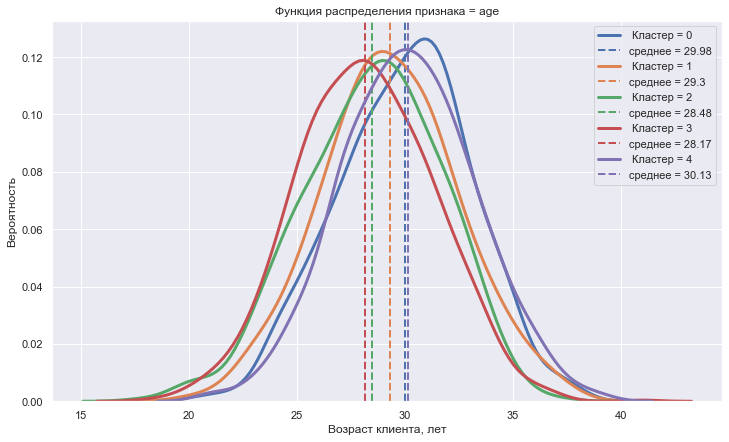

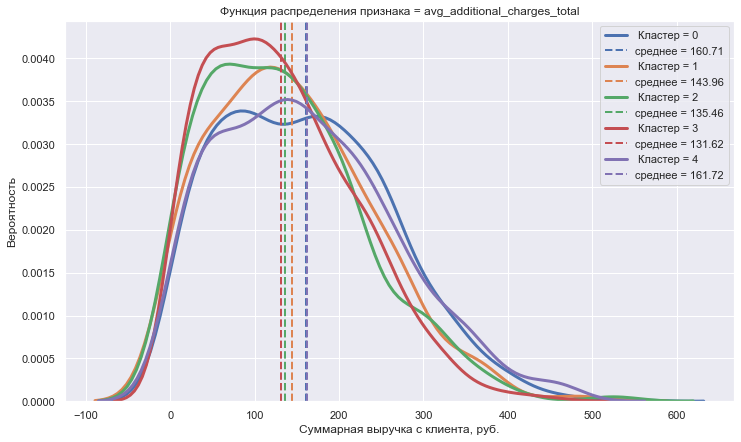

In [19]:

features =[x for x in nonbinary_features if x!='contract_period' and x!= 'month_to_end_contract']

                
plot_feature_dist_by_claster(fitness_users, features[:2], columns_rus)

- распределение для возраста похоже на нормальное, с пиком смешающимся в зависимости от кластера (0 и 4 примерно 30 лет, а 2 и 3 примерно 28 лет) 

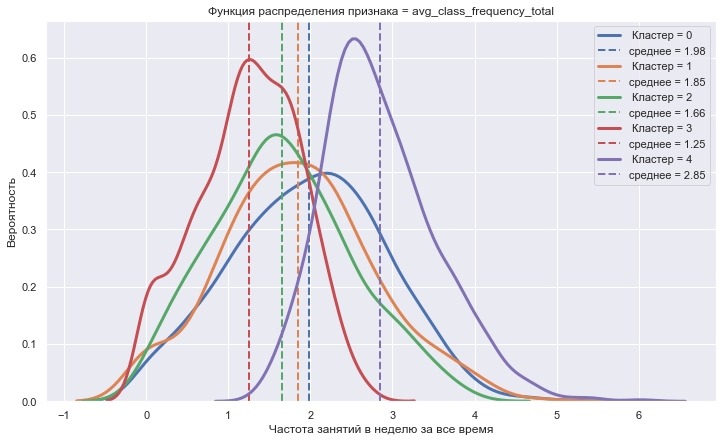

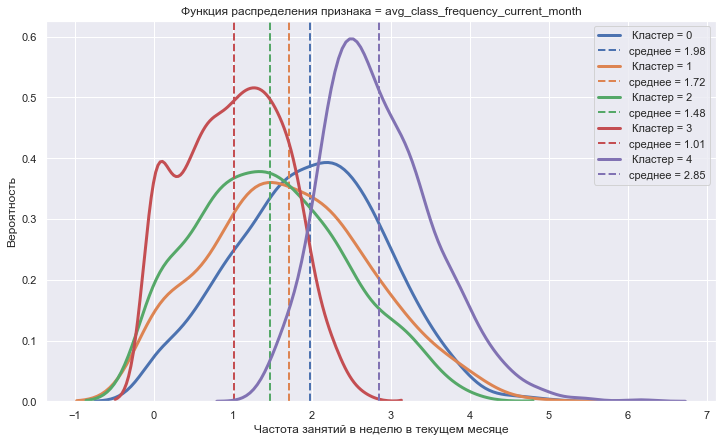

In [20]:
plot_feature_dist_by_claster(fitness_users, features[3:], columns_rus)

- Кластеры сильно отличаюся по частоте занятий в неделю всего и в текущем месяце, среднее для 3 и 4 кластера отличается почти в 2 раза), распределение в 3м и 4м кластере имеют наименьший разброс, то есть это два ярко выраженных поведения в разных кластерах

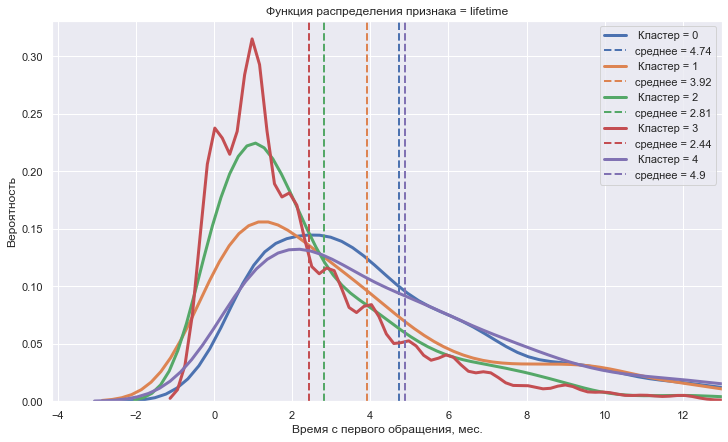

In [21]:
plot_feature_dist_by_claster(fitness_users, features[2:3], columns_rus, x_lim = 13)

- у распределения признака lifetime  очень длинный размазанный хвост со самыми "верными" клиентами, у 2го и 3го кластера самый маленький средний lifetime(около 2.5 месяцев) 

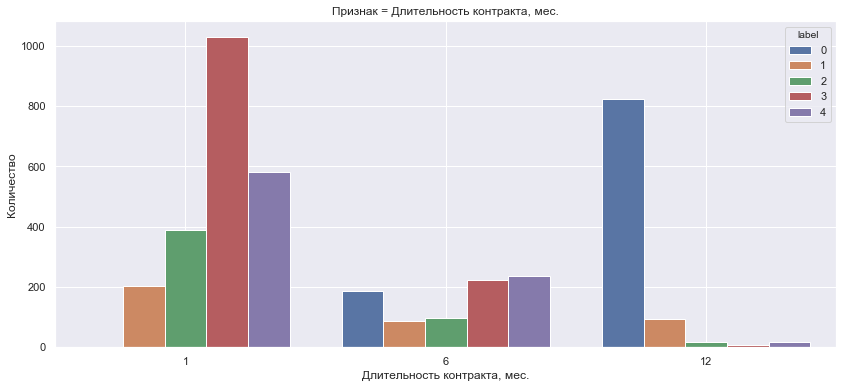

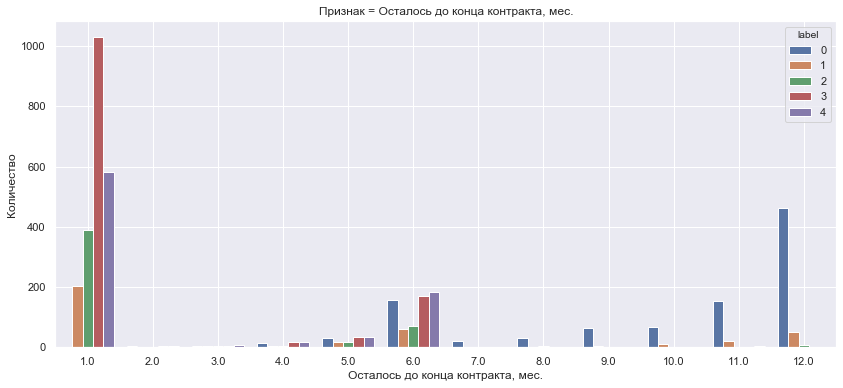

In [22]:
columns = ['contract_period' , 'month_to_end_contract']
for column in columns:
    plt.figure(figsize = (14,6))
    ax_ = sns.countplot(x = column,  hue = "label", data=fitness_users)

    ax_.grid(True)
    ax_.set(title = "Признак = " + columns_rus[column],
            xlabel = columns_rus[column], 
            ylabel = 'Количество')

    plt.show()

- в **длительности контакта** заметно, что в нулевом кластере вообще нет людей с контрактом в 1 месяц, но много тех, у кого контракт 12 месяцев
- 3й кластер состоит по большей части из клиентов с контрактом в 1 месяц плюс немного тех, у кого 6 месяцев
- 12 месяцев есть только у нулевого и первого кластера клиентов

- **остаток контракта** больше 6 месяцев встречается лишь у нулевого и немного первого кластера, у большинства кластеров(кроме 0) большую часть составляют люди с остатком в 1 месяц с небольшим количеством тех, у кого осталось 5-6 месяцев.

Для каждого полученного кластера посчитаем долю оттока клиентов:

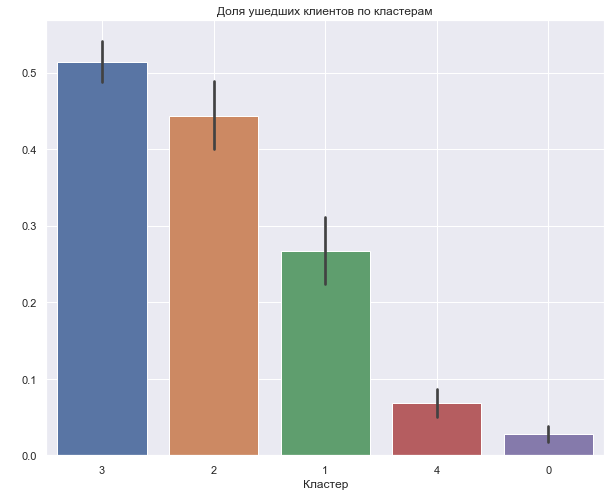

label
0   0.03
1   0.27
2   0.44
3   0.51
4   0.07
Name: churn, dtype: float64

In [23]:
plt.figure(figsize = (10,8))
ax_= sns.barplot(x = "label", y = 'churn',  data=fitness_users, order = [3,2,1,4,0],)
ax_.grid(True)
ax_.set(title = "Доля ушедших клиентов по кластерам",
        xlabel = 'Кластер', 
        ylabel = ' ')
plt.show()   

display(fitness_users.groupby('label')['churn'].mean())

Кластеры сильно отличаются по доле оттока - нулевой и четвертый кластер имеют самый низкий отток(0.03 и 0.07 соответственно), самый высокий отток во втором и третьем кластере(0.44 и 0.51), в первом кластере средний отток(0.27)


## 4. Выводы и рекомендации по работе с клиентами 

**Основные выводы:**

- Анализируя средние значения и стандартные отклонения, можно собрать следующий усредненный портрет клиентов фитнес-клуба:

    - за месяц ушло 27% посетителей(среднее Churn = 0.27); 
    - половой состав примерно 50/50 мужчины и женщины; 
    - 85% клиентов живет или работает в районе, где находится фитнес-клуб; 
    - 90% посетителей оставляет свой телефон; 
    - 49% пользуются фитнес-клубом в рамках партнерской программы от работодателя; 
    - примерно 30% воспользовались промокодом от друзей;
    - 41% клиентов посещали групповые занятия;
    - Средний возраст посетителя - 29 лет;
    - среднее количество месяцев до конца контракта и средняя длина контакта примерно 4 месяца, 50% клиентов с контрактом от 1 до 6 месяцев;
    - в среднем клиенты посещают фитнесклуб в течение 3,72 месяцев, 50% клиентов от 1 до 5 месяцев
    - средняя выручка от других услуг фитнес-клуба с клиента = 136 руб; 
    - в среднем клиент  посещает 1.88 класса в неделю, а в текущем месяце 1.77
    
-  **Средние значения** отличаются в двух группах (те, кто ушел и те, кто остался), особенно:

    - в возрасте (29.9 лет у тех, кто остался vs 26.9 лет среди тех, кто ушел)
    - общем периоде контракта (5.75 месяцев у тех, кто остался, vs 1.73 месяцев) и количестве месяце до конца контакта(5.28  vs 1.66)
    - среднем количестве занятий в неделю в текущем месяце и за все время - (2 vs 1.04 или 1.47)
    - те, кто остался в среднем были в клубе уже 4.71 месяц, а те, кто ушел, около месяца(0,99) 
    - также среди тех, кто ушел, в 2 раза меньше посещавших групповые занятия (27% vs 46%), они реже приходят по приглашению друзей (18% vs 35%) или являются сотрудниками компаний партнеров (36% vs 53%), среди них меньше тех, кто живет или работает в одном районе с фитнес-клубом
    - суммарная выручка с тех клиентов, что ушли, ниже
    
- Самая высокая корреляция между фактом оттока и следующими признаками (по величине для всех она средняя(коэффициенты корреляции около 0.4-0.5)):
    - временем с момента первого обращения в клуб 
    - средним количеством классов в текущем месяце 
    - возрастом
    - периодом контракта 
    - кол-вом месяцев до конца контракта
    
    Чем дольше человек ходит в этот клуб, чем большее количество занятий посещает в неделю, чем он старше, тем вероятнее, что он останется в клубе
    

- Вероятность оттока (на уровне следующего месяца) для каждого клиента была спрогнозирована двумя моделями(логистическая регрессия и случайный лес). Логистическая регрессия продемострировала лучше результаты на валидационной выборке: 

    - доля правильных ответов(accuracy) = 0.93 против 0.91 у случайного леса.
    - Точность(precision) = 0.88 выше 0.85 
    - полнота(recall) = 0.83% против 0.76. 

    - по коэффициентам логистической регрессии видно, что сильнее всего на целевую переменную влияют как раз сильно коррелирующие с ней признаки - время с первого посещения клуба, возраст, длительность контракта, среднее количество классов в неделю всего и за текущий месяц.

- С помощью K-means  мы выделили 5 наиболее ярких групп пользователей;

    - **Кластер  №0**:
    
        Клиенты с продолжительностью контакта намного выше среднего (10 месяцев), большинство сотрудники компаний-партнеров и пришедшие по приглашению друзей, с частотой посещения занятий чуть выше среднего, с вероятностью  90% живущие или работающие в этом районе
    
       Мне кажется, это такой кластер людей, купивших длительный абонемент(около года) в клуб поблизости от дома-работы по партнерской программе или по скидке от друзей, и теперь ходит в спортзал когда может, не очень часто, но старается, потому что это близко, и весело, потому что это форма социализации с коллегами или друзьями. Здесь самый низкий процент оттока (3%)

    - **Кластер  №1**:

        Клиенты со средней продолжительность контакта (примерно 5 месяцев), средним временем с первого посещения (чуть меньше 4 месяцев), средней частотой занятий, без контактного телефона. Это такие среднестатистические клиенты,не новички, наверное, уже с чуть меньшей мотивацией заниматься, чем в начале, со средним оттоком в 27%. 
         Возможно, отсутствие контактного телефона делает их более подверженными оттоку, чем нулевой кластер, так как им не приходят новости об акциях, событиях клуба, каких-то изменениях в расписании, они не так погружены в жизнь фитнес-клуба, как могли бы быть.
      
    - **Кластер  №2**:

         Клиенты со средней продолжительностью контракта ниже среднего (примерно 2 мес), пришедшие не по приглашению друзей (лишь 10%), а самое главное не живущих и не работающих в этом районе. Для них клуб неудобно расположен и меньше вероятность, что у клиента есть друзья в клубе, с которыми он может вместе ходить на занятия. Здесь высокий отток клиентов (44%), скорее всего люди покупают абонемент стихийно, пробуют, но их мотивации не хватает чтобы заставлять себя добираться в неудобный район,  еще и одному, без друзей.

    - **Кластер  №3**:
    
       Это самые свежие клиенты (средняя продолжительность контракта и сколько осталось до окончания контакта меньше 2 месяцев) с самой низкой частотой посещения занятий. Похоже на новичков, которые купили абонемент в фитнес в надежде "начать новую жизнь", но быстро потеряли мотивацию и перестали посещать клуб. Здесь самый высокий отток клиентов (51%)
       
    - **Кластер  №4**:
    
        Клиенты со средней продолжительностью контракта ниже среднего (примерно 2 мес), но с высокой частотой посещения занятий вообще и в текущем месяце (3 р в неделю), похоже на очень мотивированных клиентов, которые покупают короткий абонемент и активно занимаются, соответственно в этом кластере очень низкий отток (7%)
            
- Основные признаки, наиболее сильно влияющие на отток:

    - близость района к работе или жилью
    - длительность контакта
    - частота посещений
    


**Рекомендации:**

- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    - Мне кажется, тут есть две целевые группы (кластер 1 - не новички, которые теряют мотивацию со временем,  и кластер 3 - новички, которые сразу бросают, не могут замотивироваться достаточно, чтобы продолжать ходить в клуб).  У кластера 2 самая большая причина, по которой они бросают ходить в клуб - это неудобный район, с этим сложно бороться клубу, но можно направить рекламу так, чтобы больше привлекать клиентов, которые живут или работают неподалеку.
    
    - Я думаю, что для первого кластера клиентов следует увеличить вовлеченность клиентов, во-первых, узнать их контактный телефон, чтобы они могли получать какие-то новости о клубе, во-вторых, может проводить регулярно какие-то мероприятия, открывать новые направляения занятий, чтобы людям было интереснее, провести какой-то опрос, чтобы они дали фидбэк о том, чего им не хватает в фитнес-клубе.
    
    - Для третьего кластера главной задачей является понять, почему люди перестают ходить - может, нужно пересмотреть неудобное расписание, может, нужно сделать больше классов для новичков, чтобы они чувствовали себя комфортнее в первые разы в клубе, возможно их не устраивает цена за один месяц - можно предложить скидки на более длителные контракты и тогда вероятность, что человек останется, будет выше. Здесь опять же необходимо больше фидбэка от клиентов.